# DATA MODELING

Imported dataset 'features_SER', from data preparation file

In [1]:
import pandas as pd
Features = pd.read_csv('features_SER.csv')
Features.head(1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,0.000004,0.000003,0.000002,0.000002,0.000005,0.000008,0.000007,0.000005,4.245834e-07,neutral


In [2]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [3]:
X.shape, Y.shape

((36486, 162), (36486,))

In [4]:
print(Y)

['neutral' 'neutral' 'neutral' ... 'surprise' 'surprise' 'surprise']


In [5]:
import numpy as np
class_labels = np.unique(Y)

print(class_labels)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


As data has class imbalance, class weights are computed based on the distribution of classes within the dataset. These weights are applied during the model training process to prevent bias towards the majority classes.

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

# Assuming y_train is your original class labels (not one-hot encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=Y)

class_weight_dict = dict(enumerate(class_weights))

class_weights_actual = {i: class_weight_dict[i] for i in range(len(class_weight_dict))}

print(class_weights_actual)

{0: 0.7905616224648986, 1: 7.91796875, 2: 0.7905616224648986, 3: 0.7905616224648986, 4: 0.7905616224648986, 5: 0.8926893716970052, 6: 0.7905616224648986, 7: 2.331671779141104}


In [8]:
#Importing necessary libraries for model training

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(class_labels)

# Label encoding for class labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
num_classes = len(label_encoder.classes_)
y = to_categorical(Y_encoded, num_classes=num_classes)

# Splitting the data into training, validation, and test sets

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
print(y)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [11]:
# Scaling the data with sklearn's StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_val)
X_test = scaler.transform(x_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((29188, 162), (3649, 162), (3649, 162), (29188, 8), (3649, 8), (3649, 8))

In [30]:
# Reshape data for LSTM input
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [31]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [32]:
input_shape_lstm = X_train_lstm.shape[1:]
lstm_model = build_lstm_model(input_shape_lstm)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 162, 128)          66560     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 215,688
Trainable params: 215,688
Non-trainable params: 0
_________________________________________________________________


Two techniqies('Early Stopping' and 'ReduceLROnPlateau') of hyperparameter tuning are employed. These callbacks collectively contribute to effective training by preventing overfitting (EarlyStopping) and adjusting the learning rate to navigate more efficiently towards the optimal model configuration (ReduceLROnPlateau). They enhance the model's generalization ability and stability during the training process.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [34]:
# Train the model with class weights and callbacks
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights_actual,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
913/913 [==============================] - 328s 353ms/step - loss: 1.9771 - accuracy: 0.1810 - val_loss: 2.0034 - val_accuracy: 0.1014 - lr: 0.0010
Epoch 2/20
913/913 [==============================] - 314s 344ms/step - loss: 1.9619 - accuracy: 0.1752 - val_loss: 1.9440 - val_accuracy: 0.1515 - lr: 0.0010
Epoch 3/20
913/913 [==============================] - 314s 344ms/step - loss: 1.9183 - accuracy: 0.1832 - val_loss: 1.9286 - val_accuracy: 0.1395 - lr: 0.0010
Epoch 4/20
913/913 [==============================] - 317s 347ms/step - loss: 1.8831 - accuracy: 0.1907 - val_loss: 1.8515 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 5/20
913/913 [==============================] - 316s 346ms/step - loss: 1.8603 - accuracy: 0.1970 - val_loss: 1.9631 - val_accuracy: 0.1365 - lr: 0.0010
Epoch 6/20
913/913 [==============================] - 317s 347ms/step - loss: 1.7717 - accuracy: 0.2451 - val_loss: 1.8173 - val_accuracy: 0.2373 - lr: 0.0010
Epoch 7/20
913/913 [==========================

In [35]:
histroy_lstm = history

In [36]:
# Make predictions on the test set
lstm_predictions = lstm_model.predict(np.array(X_test_lstm))

115/115 [==============================] - 8s 60ms/step


In [37]:
print("Accuracy of LSTM model on test data : " , lstm_model.evaluate(x_test,y_test)[1]*100 , "%")

115/115 [==============================] - 7s 60ms/step - loss: 3.0484 - accuracy: 0.1518
Accuracy of LSTM model on test data :  15.182241797447205 %


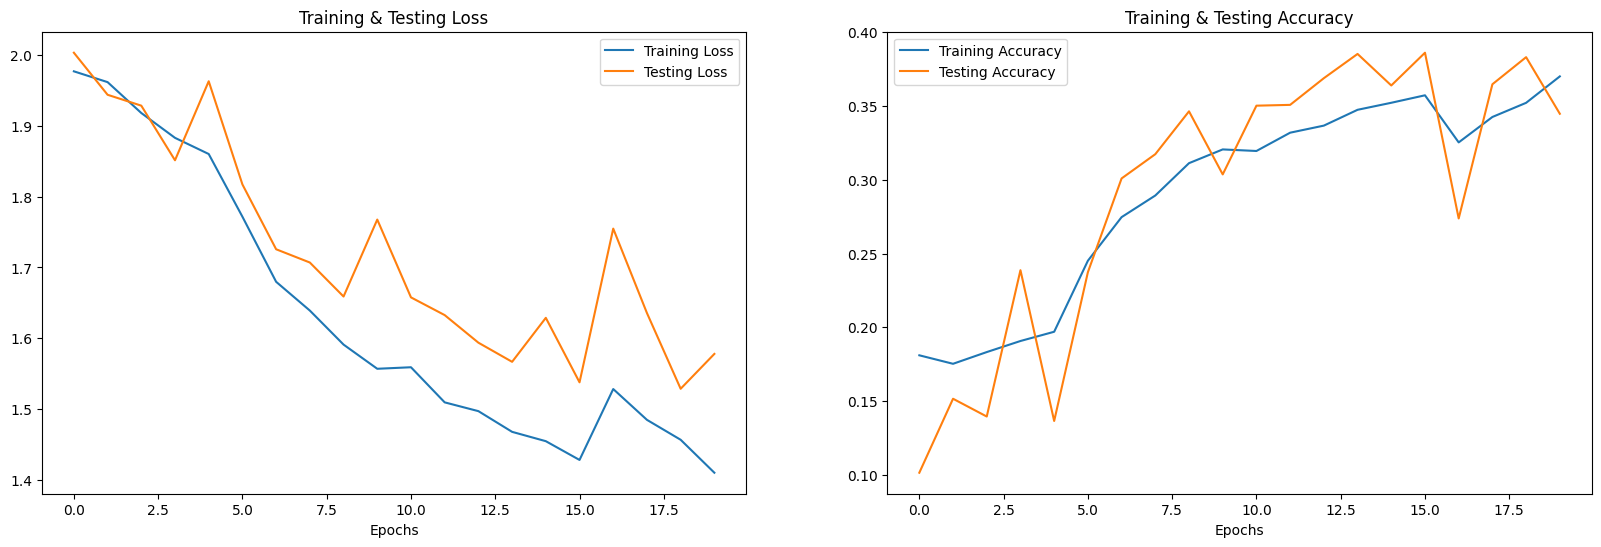

In [38]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
lstm_train_acc = histroy_lstm.history['accuracy']
lstm_train_loss = histroy_lstm.history['loss']
lstm_test_acc = histroy_lstm.history['val_accuracy']
lstm_test_loss = histroy_lstm.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , lstm_train_loss , label = 'Training Loss')
ax[0].plot(epochs , lstm_test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , lstm_train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , lstm_test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [45]:
y_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_original = np.argmax(y_test, axis=1)

115/115 [==============================] - 7s 61ms/step


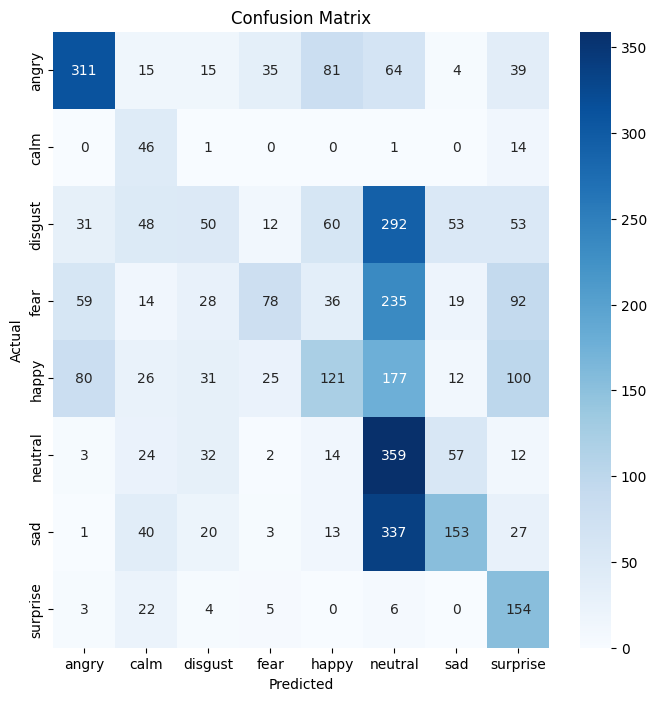

In [47]:
# Plot the confusion matrix
class_labels = label_encoder.classes_
plot_confusion_matrix(y_test_original, y_pred, class_labels)

In [48]:
print("Classification Report:")
print(classification_report(y_test_original, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.55      0.59       564
        calm       0.20      0.74      0.31        62
     disgust       0.28      0.08      0.13       599
        fear       0.49      0.14      0.22       561
       happy       0.37      0.21      0.27       572
     neutral       0.24      0.71      0.36       503
         sad       0.51      0.26      0.34       594
    surprise       0.31      0.79      0.45       194

    accuracy                           0.35      3649
   macro avg       0.38      0.44      0.33      3649
weighted avg       0.41      0.35      0.32      3649



In [13]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [14]:
# Build the CNN model
def build_cnn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(162, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    return model


In [15]:
# Reshape data for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [16]:
input_shape_lstm = X_train_cnn.shape[1:]
cnn_model = build_cnn_model(input_shape_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 80, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 78, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 256)          0

In [17]:
# Train the model with class weights and callbacks
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    class_weight=class_weights_actual,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
913/913 [==============================] - 86s 83ms/step - loss: 1.5778 - accuracy: 0.3457 - val_loss: 1.3893 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 2/20
913/913 [==============================] - 73s 80ms/step - loss: 1.2345 - accuracy: 0.4564 - val_loss: 1.2623 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 3/20
913/913 [==============================] - 73s 81ms/step - loss: 1.1451 - accuracy: 0.4952 - val_loss: 1.1904 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 4/20
913/913 [==============================] - 71s 78ms/step - loss: 1.0591 - accuracy: 0.5236 - val_loss: 1.1369 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 5/20
913/913 [==============================] - 60s 65ms/step - loss: 1.0294 - accuracy: 0.5363 - val_loss: 1.1272 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 6/20
913/913 [==============================] - 34s 38ms/step - loss: 0.9831 - accuracy: 0.5517 - val_loss: 1.1161 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 7/20
913/913 [==============================] - 28s 

In [19]:
# Make predictions on the test set
lstm_predictions = cnn_model.predict(np.array(X_test_cnn))

115/115 [==============================] - 1s 6ms/step


In [20]:
print("Accuracy of CNN model on test data : " , cnn_model.evaluate(X_test_cnn,y_test)[1]*100 , "%")

115/115 [==============================] - 1s 6ms/step - loss: 0.9654 - accuracy: 0.6257
Accuracy of CNN model on test data :  62.56508827209473 %


In [21]:
cnn_history = history

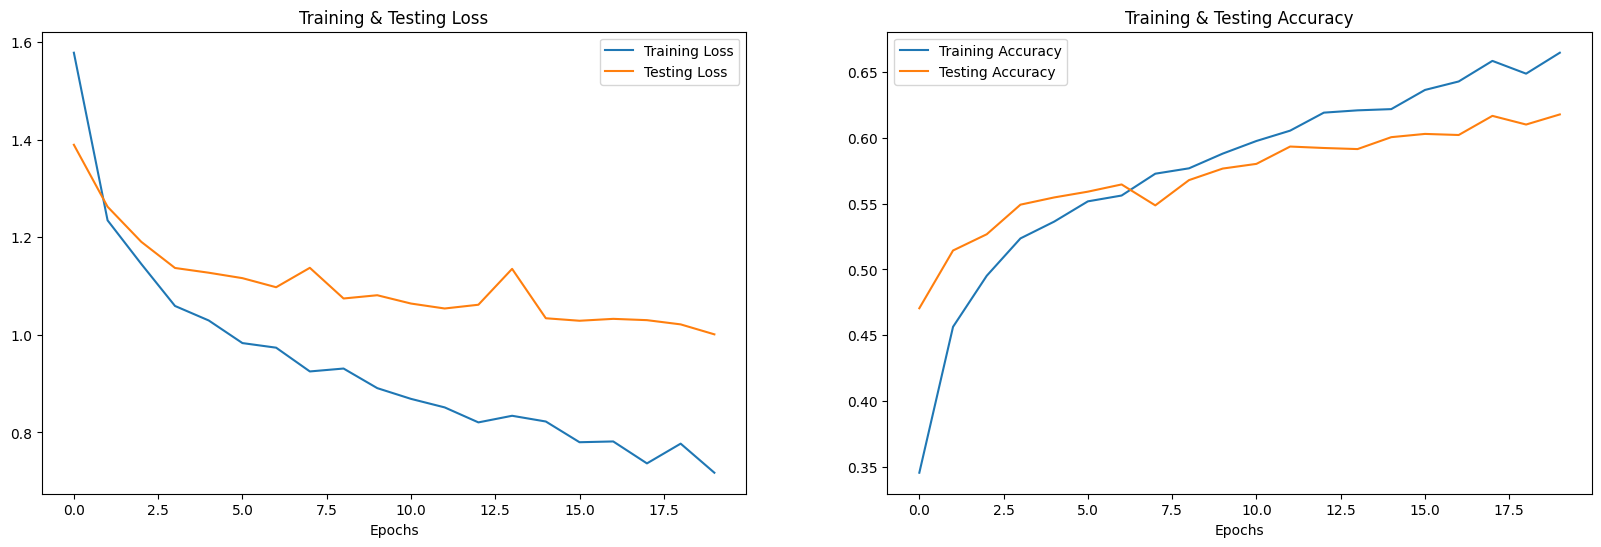

In [22]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
cnn_train_acc = cnn_history.history['accuracy']
cnn_train_loss = cnn_history.history['loss']
cnn_test_acc = cnn_history.history['val_accuracy']
cnn_test_loss = cnn_history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , cnn_train_loss , label = 'Training Loss')
ax[0].plot(epochs , cnn_test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , cnn_train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , cnn_test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred_cnn, classes):
    cm = confusion_matrix(y_true, y_pred_cnn)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [26]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
y_test_original = np.argmax(y_test, axis=1)

115/115 [==============================] - 1s 6ms/step


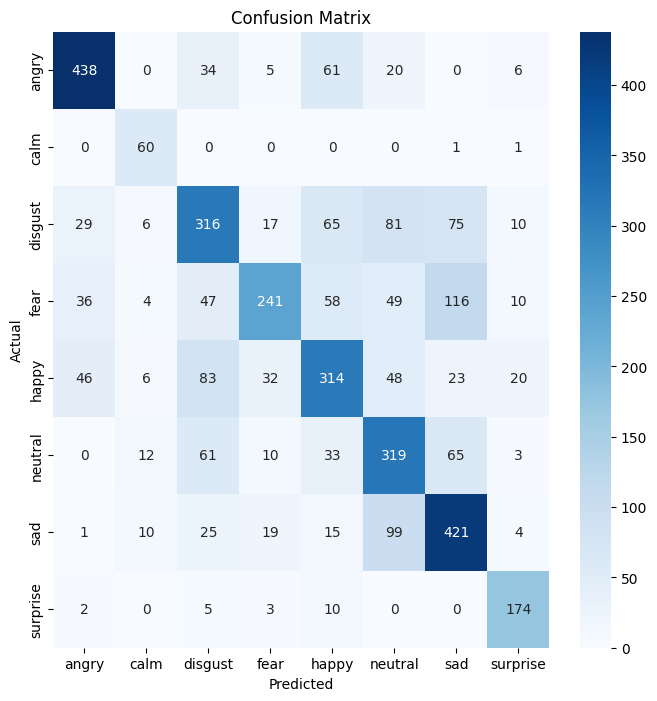

In [27]:
# Plot the confusion matrix
class_labels = label_encoder.classes_
plot_confusion_matrix(y_test_original, y_pred_cnn, class_labels)

Summary: CNN outperforms LSTM on Speech Emotion Recognition task with the accuracy close to SOTA models on individual datasets